# CAPSTONE Project: Customer Happiness
- Analysing customer happiness from hotel stays using reviews
- https://github.com/rohit6205/predictHappiness/blob/master/predictingHapiness.ipynb 
- Firm AI - Bussiness Machine Learning:
    - https://github.com/firmai/business-machine-learning

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, re, time
import numpy as np
import scipy as sp
import scipy.sparse
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns


from tqdm import tqdm_notebook

pd.set_option('display.max_columns', 50)

In [3]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer

# LOAD DATA

In [6]:
project_root = ''

In [7]:
train = pd.read_csv(os.path.join(project_root, 'train.csv'))
test = pd.read_csv(os.path.join(project_root, 'test.csv'))

In [8]:
train.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [9]:
test.head()

,User_ID,Description,Browser_Used,Device_Used
0,id80132,Looking for a motel in close proximity to TV t...,Firefox,Mobile
1,id80133,Walking distance to Madison Square Garden and ...,InternetExplorer,Desktop
2,id80134,Visited Seattle on business. Spent - nights in...,IE,Tablet
3,id80135,This hotel location is excellent and the rooms...,Edge,Mobile
4,id80136,This hotel is awesome I love the service Antho...,Mozilla,Mobile


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29404 entries, 0 to 29403
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User_ID       29404 non-null  object
 1   Description   29404 non-null  object
 2   Browser_Used  29404 non-null  object
 3   Device_Used   29404 non-null  object
dtypes: object(4)
memory usage: 919.0+ KB


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38932 entries, 0 to 38931
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User_ID       38932 non-null  object
 1   Description   38932 non-null  object
 2   Browser_Used  38932 non-null  object
 3   Device_Used   38932 non-null  object
 4   Is_Response   38932 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB


In [15]:
train['Is_Response'].value_counts(normalize=False)

happy        26521
not happy    12411
Name: Is_Response, dtype: int64

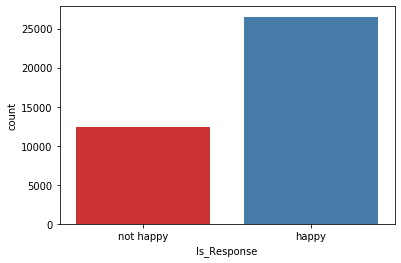

In [16]:
ax = sns.countplot(x="Is_Response", data=train, palette='Set1')

In [17]:
train.columns

Index(['User_ID', 'Description', 'Browser_Used', 'Device_Used', 'Is_Response'], dtype='object')

## Exploratory data analysis

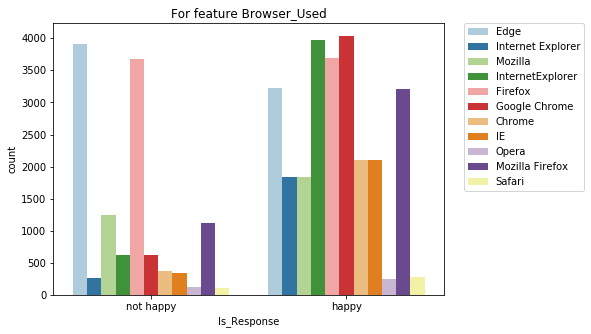

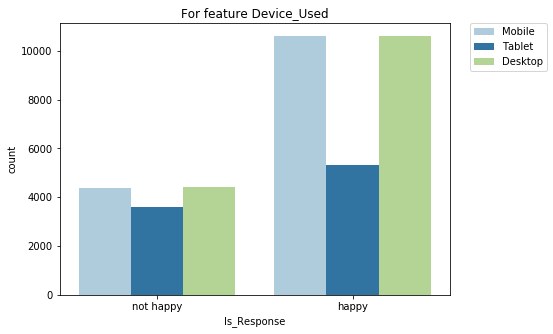

In [18]:
for col_name in ['Browser_Used', 'Device_Used']:
    plt.figure(figsize=(7,5))
    plt.title("For feature {}".format(col_name))
    sns.countplot(x="Is_Response", hue=col_name, data=train, palette='Paired')
    # Put the legend out of the figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

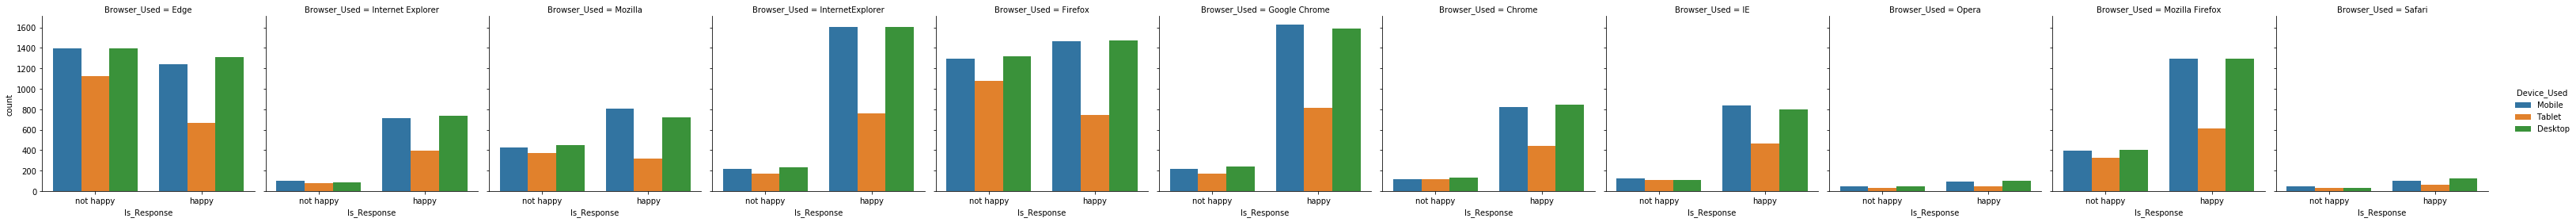

In [19]:
g = sns.catplot(x="Is_Response", hue="Device_Used", col="Browser_Used",
                data=train, kind="count",
                height=4, aspect=1);

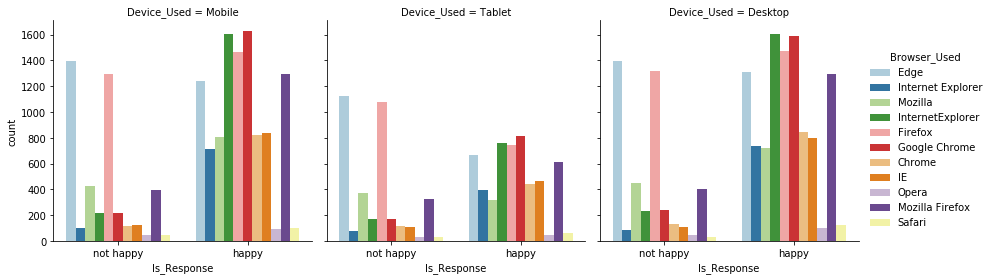

In [20]:
g = sns.catplot(x="Is_Response", hue="Browser_Used", col="Device_Used",
                data=train, kind="count",
                height=4, aspect=1, palette='Paired');

## Data Preparation

In [21]:
# function to clean data

stops = set(stopwords.words("english"))
def cleanData(text, lowercase = False, remove_stops = False, stemming = False):
    txt = str(text)
    txt = re.sub(r'[^A-Za-z0-9\s]',r'',txt)
    txt = re.sub(r'\n',r' ',txt)
    
    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])
        
    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stops])
    
    if stemming:
        st = PorterStemmer()
        txt = " ".join([st.stem(w) for w in txt.split()])

    return txt

In [23]:
#stops

In [24]:
## join data
test['Is_Response'] = np.nan
alldata = pd.concat([train, test]).reset_index(drop=True)

In [54]:
start_time = time.time()
# clean description
#alldata['Description'] = \
alldata['Description'].map(lambda x: cleanData(x, lowercase=True, remove_stops=True, stemming=True))
print("Data cleaned in {}".format(time.time() - start_time))

Data cleaned in 92.49115014076233


In [55]:
# label encode categorical features in data given
cols = ['Browser_Used','Device_Used']

for x in cols:
    lbl = LabelEncoder()
    alldata[x] = lbl.fit_transform(alldata[x])

In [56]:
alldata.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,room kind clean strong smell dog gener averag ...,1,1,not happy
1,id10327,stay crown plaza april april staff friendli at...,5,1,not happy
2,id10328,book hotel hotwir lowest price could find got ...,7,2,not happy
3,id10329,stay husband son way alaska cruis love hotel g...,6,0,happy
4,id10330,girlfriend stay celebr th birthday plan weeken...,1,2,not happy


In [57]:
# initialise the functions - we'll create separate models for each type.
countvec = CountVectorizer(analyzer='word', ngram_range = (1,1), min_df = 150, max_features=500)
tfidfvec = TfidfVectorizer(analyzer='word', ngram_range = (1,1), min_df = 150, max_features=500)

In [58]:
# create features
bagofwords = countvec.fit_transform(alldata['Description'])
tfidfdata = tfidfvec.fit_transform(alldata['Description'])

In [59]:
bagofwords

<68336x500 sparse matrix of type '<class 'numpy.longlong'>'
	with 2856714 stored elements in Compressed Sparse Row format>

In [60]:
# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)

In [61]:
tokens = countvec.get_feature_names()
wm2df(bagofwords, tokens).head()

,abl,absolut,access,accommod,across,actual,air,airport,almost,along,also,although,alway,amaz,amen,anoth,anyon,anyth,area,around,arriv,ask,attend,attent,attract,...,water,way,websit,wed,week,weekend,welcom,well,went,whole,wife,wifi,window,wine,within,without,wonder,work,worth,would,wouldnt,ye,year,york,your
Doc0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
Doc1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0
Doc2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
Doc3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Doc4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,3,0,0,0,0,0


In [62]:
# create dataframe for features
bow_df = pd.DataFrame(bagofwords.todense())
tfidf_df = pd.DataFrame(tfidfdata.todense())

# set column names
bow_df.columns = ['col'+ str(x) for x in bow_df.columns]
tfidf_df.columns = ['col' + str(x) for x in tfidf_df.columns]

In [63]:
bow_df.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,...,col475,col476,col477,col478,col479,col480,col481,col482,col483,col484,col485,col486,col487,col488,col489,col490,col491,col492,col493,col494,col495,col496,col497,col498,col499
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,3,0,0,0,0,0


In [64]:
bow_df.shape

(68336, 500)

In [65]:
train.shape

(38932, 5)

In [66]:
# create separate data frame for bag of words and tf-idf
bow_df_train = bow_df[:len(train)]
bow_df_test = bow_df[len(train):]

tfid_df_train = tfidf_df[:len(train)]
tfid_df_test = tfidf_df[len(train):]

# split the merged data file into train and test respectively
train_feats = alldata[~pd.isnull(alldata.Is_Response)]
test_feats = alldata[pd.isnull(alldata.Is_Response)]

In [67]:
train_feats['Is_Response'].head()

0    not happy
1    not happy
2    not happy
3        happy
4    not happy
Name: Is_Response, dtype: object

In [68]:
train_feats['Is_Response'].map(lambda x: int(x == "happy")).head()

0    0
1    0
2    0
3    1
4    0
Name: Is_Response, dtype: int64

In [69]:
train_feats['Is_Response'] = train_feats['Is_Response'].map(lambda x: int(x == "happy"))

/home/sageusr/anaconda3/envs/ds3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [70]:
# merge count (bag of word) features into train
train_feats1 = pd.concat([train_feats[cols], bow_df_train], axis = 1)
test_feats1 = pd.concat([test_feats[cols], bow_df_test], axis=1)

test_feats1.reset_index(drop=True, inplace=True)

# merge into a new data frame with tf-idf features
train_feats2 = pd.concat([train_feats[cols], tfid_df_train], axis=1)
test_feats2 = pd.concat([test_feats[cols], tfid_df_test], axis=1)

In [71]:
train_feats1.head()

,Browser_Used,Device_Used,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,...,col475,col476,col477,col478,col479,col480,col481,col482,col483,col484,col485,col486,col487,col488,col489,col490,col491,col492,col493,col494,col495,col496,col497,col498,col499
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0
2,7,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,3,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,3,0,0,0,0,0


In [72]:
train_feats2.head()

,Browser_Used,Device_Used,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,...,col475,col476,col477,col478,col479,col480,col481,col482,col483,col484,col485,col486,col487,col488,col489,col490,col491,col492,col493,col494,col495,col496,col497,col498,col499
0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.140913,0.0,0.0,0.0,0.0,0.29807
1,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.079735,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.092802,0.000000,0.122793,0.0,0.0,0.0,0.0,0.00000
2,7,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.128971,0.0,0.0,0.0,0.309454,0.000000,0.0,0.101295,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.101180,0.0,0.0,0.0,0.0,0.00000
3,6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.196513,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.137931,0.0,...,0.0,0.142859,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000
4,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.085415,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.087883,0.0,0.063852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08328,0.000000,0.096701,0.146196,0.0,0.0,0.0,0.0,0.00000


## Machine Learning Models - Classification

In [73]:
# let's check cross validation score of the model
# cv score acts a unbiased estimate of models accuracy on unseen data
mod1 = GaussianNB()
target = train_feats['Is_Response']

In [74]:
scores = cross_val_score(mod1, train_feats1, target, cv=5, scoring=make_scorer(accuracy_score))

# Naive Bayes 1
print(scores)
print(np.mean(scores))

[0.77205599 0.76114036 0.76753147 0.76663242 0.77626509]
0.7687250655958671


In [75]:
scores = cross_val_score(mod1, train_feats2, target, cv=5, scoring=make_scorer(accuracy_score))

# Naive Bayes 1
print(scores)
print(np.mean(scores))

[0.80904071 0.81520483 0.80901618 0.81312612 0.80349345]
0.8099762587840372


In [76]:
# make our first set of predictions
clf1 = GaussianNB()
clf1.fit(train_feats1, target)

clf2 = GaussianNB()
clf2.fit(train_feats2, target)

GaussianNB(priors=None, var_smoothing=1e-09)

In [49]:
preds1 = clf1.predict(test_feats1)
preds2 = clf2.predict(test_feats2)

In [50]:
Counter(preds1)

Counter({1: 21224, 0: 8180})

In [51]:
test_feats.shape

(29404, 5)

In [52]:
len(preds1)

29404

In [53]:
test_feats[preds1==0].head().values

array([['id80135',
        'hotel locat excel room clean suit one bedroom apart full kitchen small bathroom staff friendli help room need revis linen bed hard outdat air condition work heater could turn adjust althought cold outsid felt sauna open window air told staff certain temperatur outsid air would turn heater would go automat good thingw sweat even window open would howev stay guarante correct price size locat',
        1, 1, nan],
       ['id80144',
        'realli nice lobbi free coffe water comput printer free wifi throughout properti includ room room basic bit small adequ equip full size bed work desk small tv coffe maker bottl water self serv bathroom nice shower good toiletri less high end hotel good inexpens altern uberluxuri high end hotel charg wifi coffe fine altern solo busi travel hotel offer free downtown limo transport kitchenett avail stay longer hotel stock basic modest charg frequent guest leav cloth next trip hotel place room return tri stay cheaper altern four

In [121]:
test_feats[preds1==1].values

array([['id80132',
        'look motel close proxim tv tape dr phil show chose dune sunset blvd west hollywood although properti display aaa emblem certainli left lot desir chip scrape bottom door frame bathroom lotion contain half fullappar replac housekeep need earli wakeup call couldnt use clock radio alarm wasnt radio room tv channel list remot tv menu make view choreth tv remot return checkingout place serv purpos place revisit',
        2, 1, nan],
       ['id80133',
        'walk distanc madison squar garden penn subway station also close lot retail store restaur hotel offer free internet gym hot breakfast room top floor face th st room clean staff help accommod downsid ac make nois faucet bathroom loos thing easili fix walk hotel madison squar garden time squar broadway everyth consid definit recommend hotel friend',
        6, 0, nan],
       ['id80134',
        'visit seattl busi spent night vintag park great locat room nice bathroom nice clean thermostat didnt workhad open w

In [111]:
Counter(preds2)

Counter({0: 11450, 1: 17954})

# 'Advanced' text preparation with Spacy
- https://spacy.io/usage
- Installation (RUN in Anaconda Prompt OR using magic command ! in notebook):
    - pip install -U spacy
    - pip install -U spacy-lookups-data
    - python -m spacy download en_core_web_sm
    - python -m spacy download en_core_web_lg (larger model)

## Tokenization and lemmatization
- https://spacy.io/usage/spacy-101#annotations-token



In [39]:
import spacy
nlp_en = spacy.load('en_core_web_sm')

In [41]:
alldata['Description'].values[0]

'room kind clean strong smell dog gener averag ok overnight stay your fussi would consid stay price right breakfast free better noth'

In [42]:
doc = nlp_en(alldata['Description'].values[0])
for token in doc:
    print(token, token.pos_)

room NOUN
kind ADV
clean ADJ
strong ADJ
smell NOUN
dog NOUN
gener NOUN
averag NOUN
ok ADV
overnight ADV
stay VERB
your ADJ
fussi NOUN
would VERB
consid NOUN
stay VERB
price NOUN
right ADJ
breakfast NOUN
free VERB
better ADJ
noth NOUN


In [43]:
def get_lemma(token):
    #if '-PRON-' in token.lemma_:
    #    return token.text
    #else:
    #    return token.lemma_
    
    return token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_

def corpus_text2tokens(texts):
    corpus = []
    
    for i, txt in enumerate(texts):
        doc = nlp_en(txt)
        doc_tokens = []
        
        for token in doc:
            if not token.is_space and not token.is_punct and not token.is_digit:
                lemma = get_lemma(token)
                doc_tokens\
                .append((token.cluster, token.lemma_, lemma, token.text, \
                         token.is_stop, token.is_oov, token.pos_))
                
                
        corpus.append(doc_tokens)
        
        if i%10000 == 0:
            print(i)
        
    return corpus

#merge with above, pretrain... 
def corpus_text2entities(texts):
    corpus = []
    
    for i, txt in enumerate(texts):
        doc = nlp_en(txt)
        doc_entities = []
        
        for entity in doc.ents:
            #doc_entities.append((entity.text, entity.start_char, entity.end_char, entity.label_))
            doc_entities.append((entity.text, entity.label_))   
                
        corpus.append(doc_entities)
        
        if i%10000 == 0:
            print(i)
        
    return corpus

In [44]:
start_time = time.time()
description_corpus = corpus_text2tokens(alldata['Description'].values)
print("Finished in {}".format(time.time() - start_time))

0
10000
20000
30000
40000
50000
60000
Finished in 1368.5727479457855


In [124]:
df_words = pd.DataFrame([item for sublist in description_corpus for item in sublist], \
                 columns = ['cluster', 'lemma', 'lemma_text', 'text', 'stop', 'oov', 'pos'])\
.groupby(['cluster', 'lemma','lemma_text', 'text', 'stop', 'oov', 'pos'])\
.size()\
.reset_index()\
.rename(columns={0:'freq'})\
.sort_values(by='freq', ascending=False)

In [125]:
df_words.head()

,cluster,lemma,lemma_text,text,stop,oov,pos,freq
69984,0,room,room,room,False,True,NOUN,141546
39123,0,hotel,hotel,hotel,False,True,NOUN,138728
78625,0,stay,stay,stay,False,True,VERB,61298
56320,0,not,not,nt,False,True,ADV,53118
35274,0,great,great,great,False,True,ADJ,43643


## SELECTED TOKENS

In [123]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords